# Recursion Schemes in Scala

---

## Introduction

---

Es casi seguro que todos, de una maner o de otra, hemos oido hablar de recursión. De manera intuitiva, un objeto es recursivo si se puede definir inductivamente sobre unos casos base y unas reglas de construcción. Uno de los ejemplos más sencillos es el de los números naturales: tenemos un primer elemento llamado 0 que es un número natural y después tenemos la regla _todo número natural tiene un siguiente_. Así podemos construir todos los números que nos plazcan. De mano de los objetos recursivos, tenemos las funciones recursivas, que recorren la estructura recursiva para calcular su valor. Un nuevo ejemplo sencillo de esto es la suma de naturales. Por ejemplo, la función que suma un cierto m es:

$$
m + 0 = 0 \\

m + s(n) = s(m + n)
$$

donde s(n) es la función que asigna el siguiente de n.

La esencia es que las funciones recursivas definidas sobre una estructura inductiva recorren la estructura hasta llegar a los casos base y después van construyendo desde ese punto un resultado. 

Voliendo al mundo de la programación, uno de los ejemplos más famosos de tipos recursivos es el de Listas y Trees. Vamos a desarrollar la charla sobre un ejemplo tonto para que sea más notorio el argumento que vamos a realizar que la implementación como tal que se necesita.

Imaginemos que queremos implementar la estructura de los números enteros con las operaciones de suma y producto. Para ello, podemos definir una estructura recursiva que genere, desde los casos base (números enteros) un arbol de expresiones que recreen estas operaciones. Un ejemplo sencillo en scala sería:

In [36]:
sealed trait Ring 
case object Zero extends Ring
case object One extends Ring
case class Elem(x: Int) extends Ring
case class Add(x: Ring, y: Ring) extends Ring
case class Mult(x: Ring, y: Ring) extends Ring

defined trait Ring
defined object Zero
defined object One
defined class Elem
defined class Add
defined class Mult

Una vez tenemos la estructura, nos interesa la forma en la que podemos evaluarla. Lo primero que podemos pensar es hacer corresponder cada clase asociada a una operación con su operación correspondiente, por ejemplo:

In [37]:
def toInt: Ring => Int = {
    case Zero => 0
    case One => 1
    case Elem(x) => x
    case Add(x, y) => toInt(x) + toInt(y)
    case Mult(x, y) => toInt(x) * toInt(y)
}

defined function toInt

In [38]:
val expresion1 = Mult(Elem(4), Add(Elem(3), One))

expresion1: Mult = Mult(Elem(4), Add(Elem(3), One))

![](example.png)

In [39]:
toInt(expresion1)

res38: Int = 16

De igual manera, puede ser interesante implementar una evaluación a string:

In [40]:
def toStringR: Ring => String = {
    case Zero => 0.toString
    case One => 1.toString
    case Elem(x) => x.toString
    case Add(x, y) => toStringR(x) + " + " + toStringR(y)
    case Mult(x, y) => toStringR(x) + " * " + toStringR(y)
}


defined function toStringR

In [41]:
toStringR(expresion1)

res40: String = "4 * 3 + 1"

Si nos fijamos en las dos formas de evaluar nuestras expresiones, vemos claramente exactamente el mismo patrón. Sería interesante abstraer la noción de evaluación para que, dependiendo de lo que se quiera evaluar, se use el mismo patrón pero sobre casos diferentes (Int, String). En este punto es donde la idea de functor sale a la luz. El concepto de functor nace de una rama profunda de las matemáticas llamada teoría de categorías. Sin embargo, muchas de sus ideas encajan perfectamente en el mundo de la programación. Por lo que a nosotros respecta, un functor es una forma de constrir tipos a partir de otros y construir funciones a partir de funciones entre tipos. Siguiendo esta idea, un functor en scala tiene esta pinta:

```scala
trait Functor[F[_]] {
    def map[A,B](f: A => B): F[A] => F[B]
}
```
 Es decir, dame un tipo `A` y sé darte un tipo `F[A]`. Para las funciones es map el que nos da una función `F[A] => F[B]` a partir de A y B. Para tener los pies en la tierra, puedes convencerte de que `List[ ]` es un functor.
 
Por ejemplo, si tuviesemos nuestr anillo Ring definido sobre un tipo genérico, podríamos darle estructura de functor y ayudarnos de map para saber evaluar las expresiones de Int y String a partir de la funcón base toString: Int => String. Vamos a tener esto en mente

Otra cosa que notamos es que en estas implementaciones (a raíz de al definición de Ring) tenemos la definición de caso base y la forma de recorrerlo. Esto no es complicado en estos casos, pero los momentos de llamada a las funciones durante la recursión son una de las cosas que más dolor de cabeza puede provocar. Por poner un ejemplo tonto, si tenemos una forma de optimizar los cálculos de manera que si sumamos dos expresiones iguales nos genere esa expresión multiplicada por dos, las llamadas en su implementación pueden ser delicadas:

In [42]:
def optimizeSum: Ring => Ring = {
    case Zero => Zero
    case One => One
    case Elem(x) => Elem(x)
    case Add(x, y) => {
        if (x == y) Mult(Elem(2), optimizeSum(x))
        else Add(x, y)
    }
    case Mult(x, y) => Mult(optimizeSum(x), optimizeSum(y))
}

defined function optimizeSum

In [43]:
optimizeSum(Add(Elem(3), Elem(3)))

res42: Ring = Mult(Elem(2), Elem(3))

Como puede apreciarse, tenemos unas llamadas de optimize en diversos lugares, cosa que empieza a complicar la vida, porque el compilador no se va a dar cuenta de qeu estamos cometiendo un error al prescindir de una de sus llamadas. El problema en este caso viene, como ya hemos dicho, de haber mezclado la idea de evaluar los casos base con el recorrido de la estructura inductiva del tipo. ¿Sería posible separar estas dos ideas?

## Recursion schemes

La idea detrás de los esquemas de recursión es abstraer el paso de la recursión del caso base, de manera que podamos dar un tipo base y, por un proceso general e independiente del tipo base, generar su estructura recursiva. Para ello vamos a definir un Functor asociado al anillo que contemple únicamente los casos base (olvidando la recursión por el momento):

In [44]:
sealed trait RingF[+A]
sealed trait RingFF[+A] extends RingF[A]
case object Zero extends RingF[Nothing]
case object One extends RingF[Nothing]
case class Elem[B](x: Int) extends RingF[Nothing]
case class Add[A](x: A, y: A) extends RingF[A]
case class Mult[A](x:A, y: A) extends RingF[A]

defined trait RingF
defined trait RingFF
defined object Zero
defined object One
defined class Elem
defined class Add
defined class Mult

Hemos supuesto que el conjunto que toma la estructura de anillo es el de los enteros, más adelante generalizaremos el conjunto base (al igual que se hace `List`). 

Desde este punto, podemos definir, por un lado, la estructura de functor de este tipo `RingF[A]`. Esto es uy fácil, pues dada na función `f: A => B` podemos contruir una función `map(f): RingF[A] => RingF[B]` simplemente aplicando `f` a los argumentos de las case classes que definen `RingF`:

In [45]:
trait Functor[F[_]] {
    def map[A,B](f: A => B): F[A] => F[B]
}

defined trait Functor

In [46]:
val ringFunctor = new Functor[RingF] {
    override def map[A, B](f: A => B): RingF[A] => RingF[B] = {
        case Zero => Zero
        case One => One
        case Elem(x) => Elem(x)
        case Add(x, y) => Add(f(x), f(y))
        case Mult(x, y) => Mult(f(x), f(y))
    }
}

ringFunctor: AnyRef with Functor[RingF] = ammonite.$sess.cmd45$Helper$$anon$1@15fb0bbb

Además de tener la estructura de functor, podemos redefinir las funciones de evaluación para que se centren únicamente de los casos base:

In [47]:
def evalToInt: RingF[Int] => Int = {
    x => x match {
        case Zero => 0
        case One => 1
        case Elem(x) => x
        case Add(x, y) => x + y
        case Mult(x, y) => x*y
    }
}

def evalToStr: RingF[String] => String = {
    x => x match {
        case Zero => "0"
        case One => "1"
        case Elem(x) => x.toString
        case Add(x, y) => x + " + " + y
        case Mult(x, y) => x + " * " + y
    }
}

defined function evalToInt
defined function evalToStr

Vale, dos de los puntos que hemos comentado ya los hemos conseguido, sin embargo, esto produce algunos problemas. Si, por ejemplo, queremos definir un valor similar a `expression1` necesitamos anidar las tipos `A` dentro de RingF:

In [48]:
val expresion1F: RingF[RingF[RingF[Nothing]]] = Mult(Elem(4), Add(Elem(3), One))

expresion1F: RingF[RingF[RingF[Nothing]]] = Mult(Elem(4), Add(Elem(3), One))

Como puede verse, esta estructura dificulta mucho su construcción y no es nada cómoda. Además, otro problema es que no podemos evaluarla, porque la signatura de evalToInt es `RingF[Int]` y no una estructura anidada de `RingF[RingF[..]]`. Para solucionar esto, necesitamos abstraer RingF para que tenga un sabor recursivo. Vamos a desarrollar esto despacio porque en este punto es donde vienen las curvas.

In [27]:
val z: RingF[Int] = Add(3, 4)

evalToStr(ringFunctor.map[Int, String](x => x.toString)(z))

z: RingF[Int] = Add(3, 4)
res26_1: String = "3 + 4"

---
# Apéndice
---

In [33]:
import $ivy.`io.github.stanch::reftree:1.3.0`

import reftree.render._, reftree.diagram._
import reftree.contrib.SimplifiedInstances.string
val renderer = Renderer(renderingOptions = RenderingOptions(density = 60))

import $ivy.$                                


import reftree.render._, reftree.diagram._

import reftree.contrib.SimplifiedInstances.string

renderer: Renderer = Renderer(
  RenderingOptions(
    0.8,
    WrappedArray(
      RGBA(0.06274509803921569, 0.3058823529411765, 0.5450980392156862, 1.0),
      RGBA(0.13333333333333333, 0.5450980392156862, 0.13333333333333333, 1.0),
      RGBA(0.803921568627451, 0.3568627450980392, 0.27058823529411763, 1.0)
    ),
    "Source Code Pro",
    60
  ),
  AnimationOptions(2 seconds, 1 second, 9, true, 0),
  .,
  "png"
)

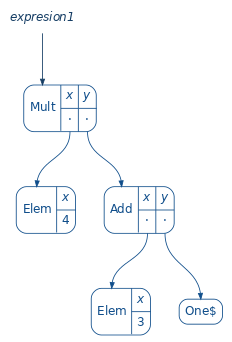

In [34]:
renderer.render("example", Diagram.sourceCodeCaption(expresion1))
Image.fromFile("example.png")

In [48]:
renderer.render("example2",  Diagram.sourceCodeCaption(expresion1F))
Image.fromFile("example2.png")

cmd48.sc:1: To render a diagram for type ammonite.$sess.cmd47.wrapper.cmd43.RingF[ammonite.$sess.cmd47.wrapper.cmd43.RingF[ammonite.$sess.cmd47.wrapper.cmd43.RingF[Nothing]]], implement an instance of reftree.core.ToRefTree[ammonite.$sess.cmd47.wrapper.cmd43.RingF[ammonite.$sess.cmd47.wrapper.cmd43.RingF[ammonite.$sess.cmd47.wrapper.cmd43.RingF[Nothing]]]]
val res48_0 = renderer.render("example2",  Diagram.sourceCodeCaption(expresion1F))
                                                                    ^Compilation Failed

: 

Todos, de una manera u otra, hemos oido hablar de recursión. Este concepto nace de la idea de usar una definición sobre sí misma para dar lugar a un nuevo objeto. Es una idea sencilla y de enorme utilidad tanto para las matemáticas como para los lenguajes deprogramación. Lo que vamos a intentar a lo largo de este trabajito es desarrollar en  detalle esta idea, hasta el punto de abstraerla lo más posible para generar un esquema general de recursión (y de evaluación de estructuras recursivas) que podamos usar tanto para entender mejor el concepto de recursión como para aplicarlo en casos de uso reales. 

### La idea de recursión: recursión en matemáticas y en computación

Es enorme la cantidad de lugares en los que este concepto es útil, uno de ellos, en el mismo corazón del formalismo matemático, en las definiciones de números naturales (a la peano) y en la definción de sus operaciones. Es decir, entendiendo las operaciones sobre números naturales como funciones $op:\mathbb{N}\times\mathbb{N}\rightarrow\mathbb{N}$, lo que tenemos son construcciones de conjuntos "_tipos_" recursivos, que son los números naturales en este caso, y el de operaciones recursivas (suma, multiplicación, exponenciación). Veamos más en detalle este ejemplo:

    
## From expresions to recursion

Imagina que tenemos una abstracción de un anillo, es decir, un conjunto en la que existen dos operaciones, suma y preocuto y un elemento neutro para cada una de ellas, 0 y 1 respectivamente. 

In [16]:
sealed trait RingF[+A, +B]
sealed trait RingFF[+A] extends RingF[A, Nothing]
case object Zero extends RingF[Nothing, Nothing] with RingFF[Nothing]
case object One extends RingF[Nothing, Nothing] with RingFF[Nothing]
case class Elem[B](x: B) extends RingF[Nothing, B]
case class Add[A](x: A, y: A) extends RingF[A, Nothing] with RingFF[A]
case class Mult[A](x:A, y: A) extends RingF[A, Nothing] with RingFF[A]

defined trait RingF
defined trait RingFF
defined object Zero
defined object One
defined class Elem
defined class Add
defined class Mult

El tipo geneŕico A nos permite dejar libre las posibles implementaciones. Una vez se tiene esta estructura genérica, resulta interesante implementar una forma de interpretarla y de evaluarla, por ejemplo, podemos definir la estructura del anillo de los enteros. Una posible evaluación es a entero, de manera que implementamos las operaciones. Otra se puede hacer sobre Strings, para tener una representación de las operacioens. 

In [28]:
def evalToInt: RingFF[Int] => Int = {
    x => x match {
        case Zero => 0
        case One => 1
        case Add(x, y) => x + y
        case Mult(x, y) => x*y
    }
}

def evalToStr: RingF[Int] => String = {
    x => x match {
        case Zero => "0"
        case One => "1"
        case Add(x, y) => x.toString + " + " + y.toString
        case Mult(x, y) => x.toString + " * " + y.toString
    }
}

cmd28.sc:3: pattern type is incompatible with expected type;
 found   : cmd28.this.cmd15.Zero.type
 required: cmd28.this.cmd15.RingFF[Int]
        case Zero => 0
             ^cmd28.sc:4: pattern type is incompatible with expected type;
 found   : cmd28.this.cmd15.One.type
 required: cmd28.this.cmd15.RingFF[Int]
        case One => 1
             ^cmd28.sc:5: constructor cannot be instantiated to expected type;
 found   : cmd28.this.cmd15.Add[A]
 required: cmd28.this.cmd15.RingFF[Int]
        case Add(x, y) => x + y
             ^cmd28.sc:6: constructor cannot be instantiated to expected type;
 found   : cmd28.this.cmd15.Mult[A]
 required: cmd28.this.cmd15.RingFF[Int]
        case Mult(x, y) => x*y
             ^Compilation Failed

: 

Uno de los puntos a tener en cuenta es que ambas evaluaciones, esencialmente, pueden obtenerse una de la otra. Dado que tenemos una transformación Int => String, tenemos una trasformación de RingF[Int] => RingF[String]. Además, esto no se limita a esta función, este comportaminto lo podemos generar de manera abstracta a partir de cualquier función genérica A => B. Es decir, que para cada f: A => B, podemos definir una función RingF[A] => RingF[B]. Esta propiedad, a groso modo, hace que RingF sea un functor. Una implemntación de esta abstracción puede ser 

In [17]:
trait Functor[F[_]] {
    def map[A,B](f: A => B): F[A] => F[B]
}

defined trait Functor

In [18]:
implicit val RingFunctor = new Functor[RingFF] {
    override def map[A, B](f: A => B): RingFF[A] => RingFF[B] = {
        x => x match {
            case Zero => Zero
            case One => One
            case Add(x, y) => Add(f(x), f(y))
            case Mult(x, y) => Mult(f(x), f(y))
        }
    }

}

RingFunctor: AnyRef with Functor[RingFF] = ammonite.$sess.cmd17$Helper$$anon$1@34199932

Una vez que tenemos esta abstracción, podemos reimplementar el evalToStrig a partir del método map

Hasta aquí todo genial, sin embargo, lo normal es que nos sepa a poco el definir operaciones binarioas de la forma 1 + 2. Si queremos definir la expresión 1 + 2x3 necesitamos cambiar la estructura a algo de la forma 


In [19]:
val z: RingFF[RingFF[Int]] = Add(One, Mult(2, 3))

z: RingFF[RingFF[Int]] = Add(One, Mult(2, 3))

Cada vez que queramos generar una expresión más complicada, necesitamos, por un lado, añadir un tipo RingF al constructor y, además, redefinir el método evaltoInt. Esto da lugar a una estructura recursiva sobre las expresiones que generan las operaciones del anillo y, además, una dependencia en la forma de evaluarlo. Una de las posibles soluciones, y la más directa, es usar una extensión recursiva sobre RingF de manera que tengamos

In [5]:
sealed trait DirectRingF 
case object Zero extends DirectRingF
case object One extends DirectRingF
case class Add(x: DirectRingF, y: DirectRingF) extends DirectRingF
case class Mult(x: DirectRingF, y: DirectRingF) extends DirectRingF

def directEval: DirectRingF => Int = {
    x => x match {
        case Zero => 0
        case One => 1
        case Add(x, y) => directEval(x) + directEval(y)
        case Mult(x, y) => directEval(x) * directEval(y)
    }
}

defined trait DirectRingF
defined object Zero
defined object One
defined class Add
defined class Mult
defined function directEval

Esta sintaxis es perfectamente correcta. Sin embargo, se pierde queda un poco oscuro el paso de la evaluación de las expresiones de los nodos y las de las hojas. Por ello, y para disfrutar rompiéndonos un poco la cabeza, vamos a tratar de pensar en lo qeu significa la estructura recursiva en este caso.

En primer lugar, tenemos un functor, es decir, un tipo que come otros tipos para generar otros nuevos. en nuestro caso, es de la forma

A => F[A] => F[F[A]] => ...

Además, si conocemos una evaluación concreta, por ejemplo, de tipo Int, tenemos una función F[Int] => Int. Es hora de empezar a dar nombre a esta estructura, es lo que se llama una F-álgebra. Más en concreto, dado un functor F una F-álgebra es un par (f, A), donde A es un tipo concreto y f es una aplicaión F[A] => A.

Por ejemplo, (evalToInt, Int) es una RingF-álgebra. Básicamente, las F-álgebras codifican la manera en la que podemos evaluar expresiones generadas a partir del functor dado. 

Por otro lado, si tratamos de imaginar la idea de recursión para un cierto functor F, es como el resultado de aplicar F una cantidad infinita de veces, de manera que siempre pudiesemos cosntrur cualquier expresión a partir de la composición de objetos de tipo RingF[RingF[...]]. Es decir, el tipo recursivo, H,  para RingF debe ser un tipo con la propiedad de que RingF[H] = H, es decir, el final de la cadena de composiciones del functor RingF. A partir de la ecuación anterior, al tipo recursivo asociado a RingF se le conoce como punto fijo. Esta idea nos permite abstraer la noción de recursión y codificarla en la idea de los puntos fijos. Una implementación sencilla de un punto fijo genérico para un functor es el siguiente.

In [21]:
case class Fix[F[_]](unfix: F[Fix[F]] )
object Fix {
  def in[F[_]](ff: F[Fix[F]]): Fix[F] = new Fix[F](ff)
  def out[F[_]]: Fix[F] => F[Fix[F]] = f => f.unfix
}

defined class Fix
defined object Fix

Las funciones in y out son las que representan la igualdad de tipos ya que podemos ir de un tipo a otro sin perder nada de información (es un isomorfismo). A partir de este tipo, podemos contruir nuestros tipo recursivo asociado al functo RingF de la manera siguiente

In [22]:
type Ring = Fix[RingFF]
val zero = Fix[RingFF](Zero)
val one =  Fix[RingFF](One)
def add: (Ring, Ring) => Ring = (x, y) =>  Fix[RingFF](Add(x, y))
def mult: (Ring, Ring) => Ring = (x, y) =>  Fix[RingFF](Mult(x, y))

defined type Ring
zero: Fix[RingFF] = Fix(Zero)
one: Fix[RingFF] = Fix(One)
defined function add
defined function mult

Con esto, ya podemos definir expresiones tan complejas ocmo deseemos:

In [24]:
val r = mult(add(one, one), add(add(one, one), one))

r: Ring = Fix(
  Mult(
    Fix(Add(Fix(One), Fix(One))),
    Fix(Add(Fix(Add(Fix(One), Fix(One))), Fix(One)))
  )
)

Uno de los objetivos lo hemos conseguido, en realidad, el trait Fix nos permite construir la estructura recursiva de cualquier functor, es decir, que dada cualquier definición de tipos sobre el caso base, podemos levantarla a su estructura recursiva. Sin embargo, esto no es muy interesanete si no podemos hacer lo mismo con las evaluaciones. Ya hemos comentado que las evaluaciones se basan en F-álgebras. 

In [12]:
type Algebra[F[_], A] = F[A] => A

defined type Algebra

A partir de este punto, nos gustaria deducir cómo funciona la evaluación de las estructuras recursivas a partir de un álgebra concreta. Es aquí donde entra en juego de manera crucial que F sea un functor y que, por tanto, pueda generar aplicaciones entre las tipos contruidos con F. Sea i el punto fijo del functor F, tenemos que F[i] = i ( en el sentido de las aplicaciones, es decir que:

F[i] -----> F[A]
 |             |
 |             |
 i ---------> A
 
 tenemos bien definidas tanto la aplicación in, como out, como el evaluador. Podemos contruir las dos funciones que conectan el álgebra del punto fijo con el ágebra dada. La respuesta es que sí, y esta función no depende del álgebra inicial: 

In [13]:
def cata[F[_], A](alg: Algebra[F, A])(implicit F: Functor[F]): Fix[F] => A = {
    x => alg((F.map(cata(alg))(Fix.out(x))))
}

defined function cata

Con esta función, ya podemos generar la versión recursiva de evalToInt

In [15]:
def evalToInt: Algebra[RingF, Int] = {
    x => x match {
        case Zero => 0
        case One => 1
        case Add(x, y) => x + y
        case Mult(x, y) => x*y
    }
}
cata(evalToInt)(RingFunctor)(exp)

defined function evalToInt
res14_1: Int = 3

## Recursive data Types

Uno de los ejemplos más claros de tipos recursivos es el de litas. Una implementación sencilla sería 

---

In [16]:
import annotation.tailrec
@tailrec
def expand(n: Int, x: List[Int], i: Int): List[Int] = {
    val z = x
    n match {
        case 0 =>  z
        case _ => expand(n-1, i::x, i)
    }
}

import annotation.tailrec

defined function expand

In [17]:
//Hacer esto de manera funcional, que es feo de cojones

def mult(x: List[Int], y: List[Int]): List[Int] = {
    val max = if (x.length >= y.length) x else y
    val min = if (x.length < y.length) x else y
    val fillmin = expand(max.length - min.length, min, 1)
    var res = expand(2*(max.length)-1, Nil, 0).toArray
    for (i <- (0 to (x.length-1))) {
        for (j <- (0 to (y.length-1))) {
            res(i + j) +=x(i)*y(j) 
        }
    }
    return res.toList
}
def evalToPol(x: List[Int]) = {
    var res = ""
    for (i <- (0 to x.length-1)) {
        res += x(x.length-1-i)+" x^" + i + " + "
    }
    res
}



defined function mult
defined function evalToPol

In [20]:
val x = 2::3::Nil
val y = 3::2::1::Nil
evalToPol(mult(List(3), List(2, 4)))

x: List[Int] = List(2, 3)
y: List[Int] = List(3, 2, 1)
res19_2: String = "0 x^0 + 12 x^1 + 6 x^2 + "

In [22]:
type Pol = List[Int]
def evalPol: Algebra[RingF, Pol] = {
    x => x match {
        case Zero => 0::Nil
        case One => 1::Nil
        case Add(x, y) => {
            val max =  if (x.length >= y.length) x else y
            val min = if (x.length >= y.length) y else x
            val N = max.length - min.length
            val nmin= expand(N, min, 0)
            max.zip(min).map(x => x match {
                case (i, j) => i + j
            })
        }
        case Mult(x, y) => mult(x, y)
        
    }
}

type PolRing = RingF[Pol]
add(const())

defined type Pol
defined function evalPol
defined type PolRing

In [4]:
sealed trait myList[+A]
case object Nill extends myList[Nothing]
case class Cons[A](h: A, t: myList[A]) extends myList[A]

defined trait myList
defined object Nill
defined class Cons

Como puede verse, tenemos un caso base que es la lista vacía y un elemento Cons que representa la lista formada por una cabecera y su cola. 

In [22]:
trait Functor[F[_]] {
    def map[A, B](f: A => B): F[A] => F[B]
}

sealed trait ExprF[A] 
final case class c[A](x: Double) extends ExprF[A] 
final case class  v[A](x: String) extends ExprF[A]
final case class  add[A](x: A, y: A) extends ExprF[A]
final case class  times[A](x: A, y : A) extends ExprF[A]
val exprfunctor = new Functor[ExprF] {
    override def map[A, B](f: A => B): ExprF[A] => ExprF[B] = {
        exp1 => exp1 match {
            case c(x) => c(x)
            case v(s) => v(s)
            case add(a, b) => add(f(a), f(b))
            case times(a, b) => times(f(a), f(b))
        }
    }
}

defined trait Functor
defined trait ExprF
defined class c
defined class v
defined class add
defined class times
exprfunctor: AnyRef with Functor[ExprF] = ammonite.$sess.cmd21$Helper$$anon$1@50432c7f

In [23]:
type Algebra[F[_], A] = F[A] => A

defined type Algebra

In [24]:
case class Assing(value: Double, variable: String)

def evalStr: Algebra[ExprF, String] = {
x => x match {
    case c(x) => x.toString
    case v(x) => x
    case add(a, b) => a + " + " +  b
    case times(a, b) => "(" + a + ")" + "*" +"(" + b + ")"
    }
}

def evalDouble(y: Assing*): Algebra[ExprF, Double] = {
    x => x match {
        case c(x) => x
        case v(x) => {
            val value = y.filter(z => z.variable == x)
            if (value.length > 0) value(0).value else 0
    }
        case add(a, b) => a + b
        case times(a, b) => a * b
}
}

defined class Assing
defined function evalStr
defined function evalDouble

In [25]:
case class Fix[F[_]](unfix: F[Fix[F]] )
object Fix {
  def in[F[_]](ff: F[Fix[F]]): Fix[F] = new Fix[F](ff)
  def out[F[_]]: Fix[F] => F[Fix[F]] = f => f.unfix
}

defined class Fix
defined object Fix

In [26]:
type Expr = Fix[ExprF]
def Var: String => Expr = s => Fix[ExprF](v(s))
def Const: Double => Expr = x => Fix[ExprF](c(x))
def Add: (Expr, Expr) => Expr = (a, b) => Fix[ExprF](add(a, b))
def Times: (Expr, Expr) => Expr = (a, b) => Fix[ExprF](times(a, b))


defined type Expr
defined function Var
defined function Const
defined function Add
defined function Times

In [27]:
val x = Add(Add(Var("x"), Const(7)), Add(Var("x"), Const(7)))

x: Expr = Fix(
  add(Fix(add(Fix(v("x")), Fix(c(7.0)))), Fix(add(Fix(v("x")), Fix(c(7.0)))))
)

In [27]:
zero: Nat = Fix(Zero)

(console):1:11 expected (Semis | &"}" | end-of-input)
zero: Nat = Fix(Zero)
          ^

: 

In [28]:
sealed trait NatF[+A]
case object Zero extends NatF[Nothing]
case class Succ[A](x: A) extends NatF[A]

val NatFunctor = new Functor[NatF] {
    override def map[A,B](f: A => B): NatF[A] => NatF[B] = {
        case Zero => Zero
        case Succ(x) => Succ(f(x))
    }
}

type Nat = Fix[NatF]
val zero: Nat =  Fix[NatF](Zero)
def suc: Nat => Nat = x =>  Fix[NatF](Succ(x))

defined trait NatF
defined object Zero
defined class Succ
NatFunctor: AnyRef with Functor[NatF] = ammonite.$sess.cmd27$Helper$$anon$1@5601c43e
defined type Nat
zero: Nat = Fix(Zero)
defined function suc

In [29]:
val num = suc(suc(zero))

num: Nat = Fix(Succ(Fix(Succ(Fix(Zero)))))

In [30]:
def evalToInt: Algebra[NatF, Int] = {
    x => x match {
        case Zero => 0
        case Succ(x) => x + 1 
    }
}
def evaltoFib: Algebra[NatF, (Int, Int)] = {
    case Zero => (1, 1)
    case Succ((n, m)) => (m, n+m) 
}


defined function evalToInt
defined function evaltoFib

In [30]:
cata(evalStr)(exprfunctor)(x)

cmd30.sc:1: type mismatch;
 found   : ammonite.$sess.cmd23.wrapper.cmd22.Algebra[ammonite.$sess.cmd23.wrapper.cmd21.ExprF,String]
    (which expands to)  ammonite.$sess.cmd23.wrapper.cmd21.ExprF[String] => String
 required: ammonite.$sess.cmd18.wrapper.cmd16.Algebra[F,String]
    (which expands to)  F[String] => String
val res30 = cata(evalStr)(exprfunctor)(x)
                 ^Compilation Failed

: 

In [30]:
cata(evalDouble(Assing(3, "x")))(exprfunctor)(x)

cmd30.sc:1: type mismatch;
 found   : ammonite.$sess.cmd23.wrapper.cmd22.Algebra[ammonite.$sess.cmd23.wrapper.cmd21.ExprF,Double]
    (which expands to)  ammonite.$sess.cmd23.wrapper.cmd21.ExprF[Double] => Double
 required: ammonite.$sess.cmd18.wrapper.cmd16.Algebra[F,Double]
    (which expands to)  F[Double] => Double
val res30 = cata(evalDouble(Assing(3, "x")))(exprfunctor)(x)
                           ^Compilation Failed

: 

In [30]:
cata(evaltoFib)(NatFunctor)(suc(num))

cmd30.sc:1: type mismatch;
 found   : ammonite.$sess.cmd29.wrapper.cmd22.Algebra[ammonite.$sess.cmd29.wrapper.cmd27.NatF,(Int, Int)]
    (which expands to)  ammonite.$sess.cmd29.wrapper.cmd27.NatF[(Int, Int)] => (Int, Int)
 required: ammonite.$sess.cmd18.wrapper.cmd16.Algebra[F,(Int, Int)]
    (which expands to)  F[(Int, Int)] => (Int, Int)
val res30 = cata(evaltoFib)(NatFunctor)(suc(num))
                 ^Compilation Failed

: 

In [45]:
cata(evalToInt)(NatFunctor)(num)

res3: Int = 2


In [3]:
%load_ext itikz

<console>: 26: error: not found: value %

In [4]:
%%itikz
\documentclass{standalone}
\usepackage{tikz-cd}
\usepackage{adjustbox}
\begin{document}
\adjustbox{scale=3,center}{%
    \begin{tikzcd}
    X \arrow[r, hook] \arrow[dr, dashrightarrow]
    & \bar{X} \arrow[d]\\
    & Y
    \end{tikzcd}
}
\end{document}

<console>: 4: error: error in unicode escape